D:\AGH\Projects\ANN\CNN_autoencoder\project\env\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1792])) that is different to the input size (torch.Size([3, 1792])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\AGH\Projects\ANN\CNN_autoencoder\project\env\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1792])) that is different to the input size (torch.Size([2, 1792])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\AGH\Projects\ANN\CNN_autoencoder\project\env\lib\site-packages\torch\optim\lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate comput

epoch [1/100], loss:0.1855, lr:0.100000000
epoch [2/100], loss:0.1843, lr:0.100000000
epoch [3/100], loss:0.1837, lr:0.100000000
epoch [4/100], loss:0.1835, lr:0.100000000
epoch [5/100], loss:0.1832, lr:0.100000000
epoch [6/100], loss:0.1831, lr:0.100000000
epoch [7/100], loss:0.1831, lr:0.100000000
epoch [8/100], loss:0.1830, lr:0.100000000
epoch [9/100], loss:0.1829, lr:0.100000000
epoch [10/100], loss:0.1828, lr:0.100000000
epoch [11/100], loss:0.1828, lr:0.100000000
epoch [12/100], loss:0.1828, lr:0.100000000
epoch [13/100], loss:0.1830, lr:0.100000000
epoch [14/100], loss:0.1828, lr:0.100000000
epoch [15/100], loss:0.1833, lr:0.100000000
epoch [16/100], loss:0.1836, lr:0.100000000
epoch [17/100], loss:0.1832, lr:0.100000000
epoch [18/100], loss:0.1830, lr:0.100000000
epoch [19/100], loss:0.1829, lr:0.100000000
epoch [20/100], loss:0.1819, lr:0.100000000
epoch [21/100], loss:0.1806, lr:0.001000000
epoch [22/100], loss:0.1793, lr:0.010000000
epoch [23/100], loss:0.1793, lr:0.0100000

KeyboardInterrupt: 

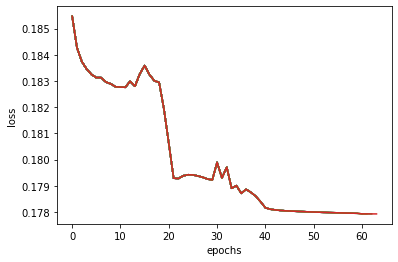

In [2]:

__author__ = 'SherlockLiao'

import os
from pathlib import Path

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import StepLR

if not os.path.exists('./simp_aut_img'):
    os.mkdir('./simp_aut_img')


num_epochs = 100
batch_size = 3
learning_rate = 0.1

img_transform = transforms.Compose([
    transforms.ToTensor()
])
#,transforms.Normalize([0.5], [0.5])

    # Define data directory
data_dir = Path(os.getcwd()).parent / 'data_SingleRow_sweepEachBit'
training_dir = data_dir / 'training'
x_dir = training_dir / 'x'
y_dir = training_dir / 'y'

    # Read data
indexes = range(0,590) #range(0,6999)
indexes_leading_zero = [str(index).zfill(5) for index in indexes]
files_names = [index + '.bin' for index in indexes_leading_zero]
x = np.array([np.fromfile(x_dir / file, 'uint8') for file in files_names])
y = np.array([np.fromfile(y_dir / file, 'uint8') for file in files_names])

train_data = torch.from_numpy(x)
train_data = train_data.to(torch.float)
dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)

reconstructed_data = torch.from_numpy(y)
reconstructed_data = reconstructed_data.to(torch.float)
reconstructed_loader = torch.utils.data.DataLoader(reconstructed_data, batch_size=batch_size, shuffle=False)


class autoencoder(nn.Module):
    def __init__(self, n_bottleneck):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            #single row of pixels is 1792 elements
            nn.Linear(1792, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, n_bottleneck))
        self.decoder = nn.Sequential(
            nn.Linear(n_bottleneck, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 1792),
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

torch.manual_seed(10)

n_bottleneck = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = autoencoder(n_bottleneck).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adagrad(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

loss_history = []
for epoch in range(num_epochs):
    for idx, data in enumerate(dataloader):
        img = data
        img = img.view(img.size(0), -1)
        img = Variable(img).to(device)
        target = reconstructed_data[idx]
        target = Variable(target).to(device)
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, target)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}, lr:{:.9f}'
          .format(epoch + 1, num_epochs, loss.item(), scheduler.get_lr()[0])) #loss.data[0]
    # if epoch % 10 == 0:
    #     pic = output.cpu().data #to_img(output.cpu().data)
    #     save_image(pic, './simp_aut_img/image_{}.png'.format(epoch))
    scheduler.step()

    #Plot history
    loss_history.append(loss.item())
    plt.plot(loss_history)
    plt.xlabel('epochs')
    plt.ylabel('loss')

#torch.save(model.state_dict(), './sim_autoencoder.pth')



